#### 라이브러리 불러오기

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 시계열 데이터의 주파수 성분 분석 라이브러리
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

#### 설정

In [2]:
%config InlineBackend.figure_format = 'retina'

#### 데이터 가져오기

In [3]:
BASE_PATH = os.path.join(os.getcwd(), 'data')

In [4]:
tunnel_df = pd.read_csv(os.path.join(BASE_PATH, 'tunnel.csv'))
tunnel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Day          747 non-null    object
 1   NumVehicles  747 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


#### 데이터 전처리

In [5]:
# 'Day'컬럼을 날짜 형식으로 변환
tunnel_df.Day = pd.to_datetime(tunnel_df.Day)

# 'Day'컬럼을 인덱스로 지정
tunnel_df = tunnel_df.set_index('Day')

In [6]:
tunnel_df.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [7]:
# 'Day'컬럼을 기간 단위로 변환:
# 시계열 분석 및 집계, 주기성(계절성) 분석에 용이
tunnel_df = tunnel_df.to_period('D')

In [8]:
tunnel_df.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


##### 날짜관련 컬럼 추가

In [9]:
work_df = tunnel_df.copy()

In [10]:
work_df['day'] = work_df.index.day_of_week
work_df['week'] = work_df.index.week
work_df['day_of_year'] = work_df.index.day_of_year
work_df['year'] = work_df.index.year
work_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 747 entries, 2003-11-01 to 2005-11-16
Freq: D
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   NumVehicles  747 non-null    int64
 1   day          747 non-null    int64
 2   week         747 non-null    int64
 3   day_of_year  747 non-null    int64
 4   year         747 non-null    int64
dtypes: int64(5)
memory usage: 35.0 KB


In [11]:
work_df.year.value_counts()

year
2004    366
2005    320
2003     61
Name: count, dtype: int64

#### 시각화

##### 시각화 함수 정의

In [23]:
def seasonal_plot(x, y, period, freq, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
        
    palette = sns.color_palette('husl', n_colors=x[period].nunique())
    
    ax = sns.lineplot(
        x=freq, y=y, hue=period, data=x, errorbar=('ci', False), 
        ax=ax, palette=palette, legend=False
    )
    ax.set_title(f'Seasonal Plot ({period}/{freq})')
    
    for line, name in zip(ax.lines, x[period].unique()):
        _y = line.get_ydata()[-1]
        ax.annotate(
            name, xy=(1, _y), xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords='offset points',
            size=14,
            va='center'
        )
        
    return ax

In [25]:
def plot_periodogram(ts, detrend='linear', ax=None):
    # 아래 코드가 에러가 나기 때문에 그냥 365.25(1년의 일수)를 적용해줌
    # fs = pd.Timedelta('1Y') / pd.TimeDelta('1D')
    fs = 365.25
    # 시계열 데이터의 주파수 성분 계산을 위한 `주기 그램(period gram)` 계산
    freqencies, spectrum = periodogram(
        ts,                 # 주기 그램을 계산한 시계열 데이터
        fs=fs,              # 샘플링 주파수(1년을 몇 일로 간주할 것인지 나타냄)
        detrend=detrend,    # 추세 제거 여부를 나타내는 매개변수
        scaling='spectrum', # 스케일링 방법(spectrum: 주파수 스펙트럼)
    )
    
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color='purple')
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [                       # 단위
            'Annual (1)',       # 년
            'Semiannual (2)',   # 반년 
            'Quarterly (4)',    # 분기
            'Bimonthly (6)',    # 격월
            'Monthly (12)',     # 월
            'Biweekly (26)',    # 2주
            'Weekly (52)',      # 주
            'Semiweekly (104)'  # 1/2주
        ],
        rotation=30
    )
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_ylabel('Variance')
    ax.set_title('Periodogram')
    return ax

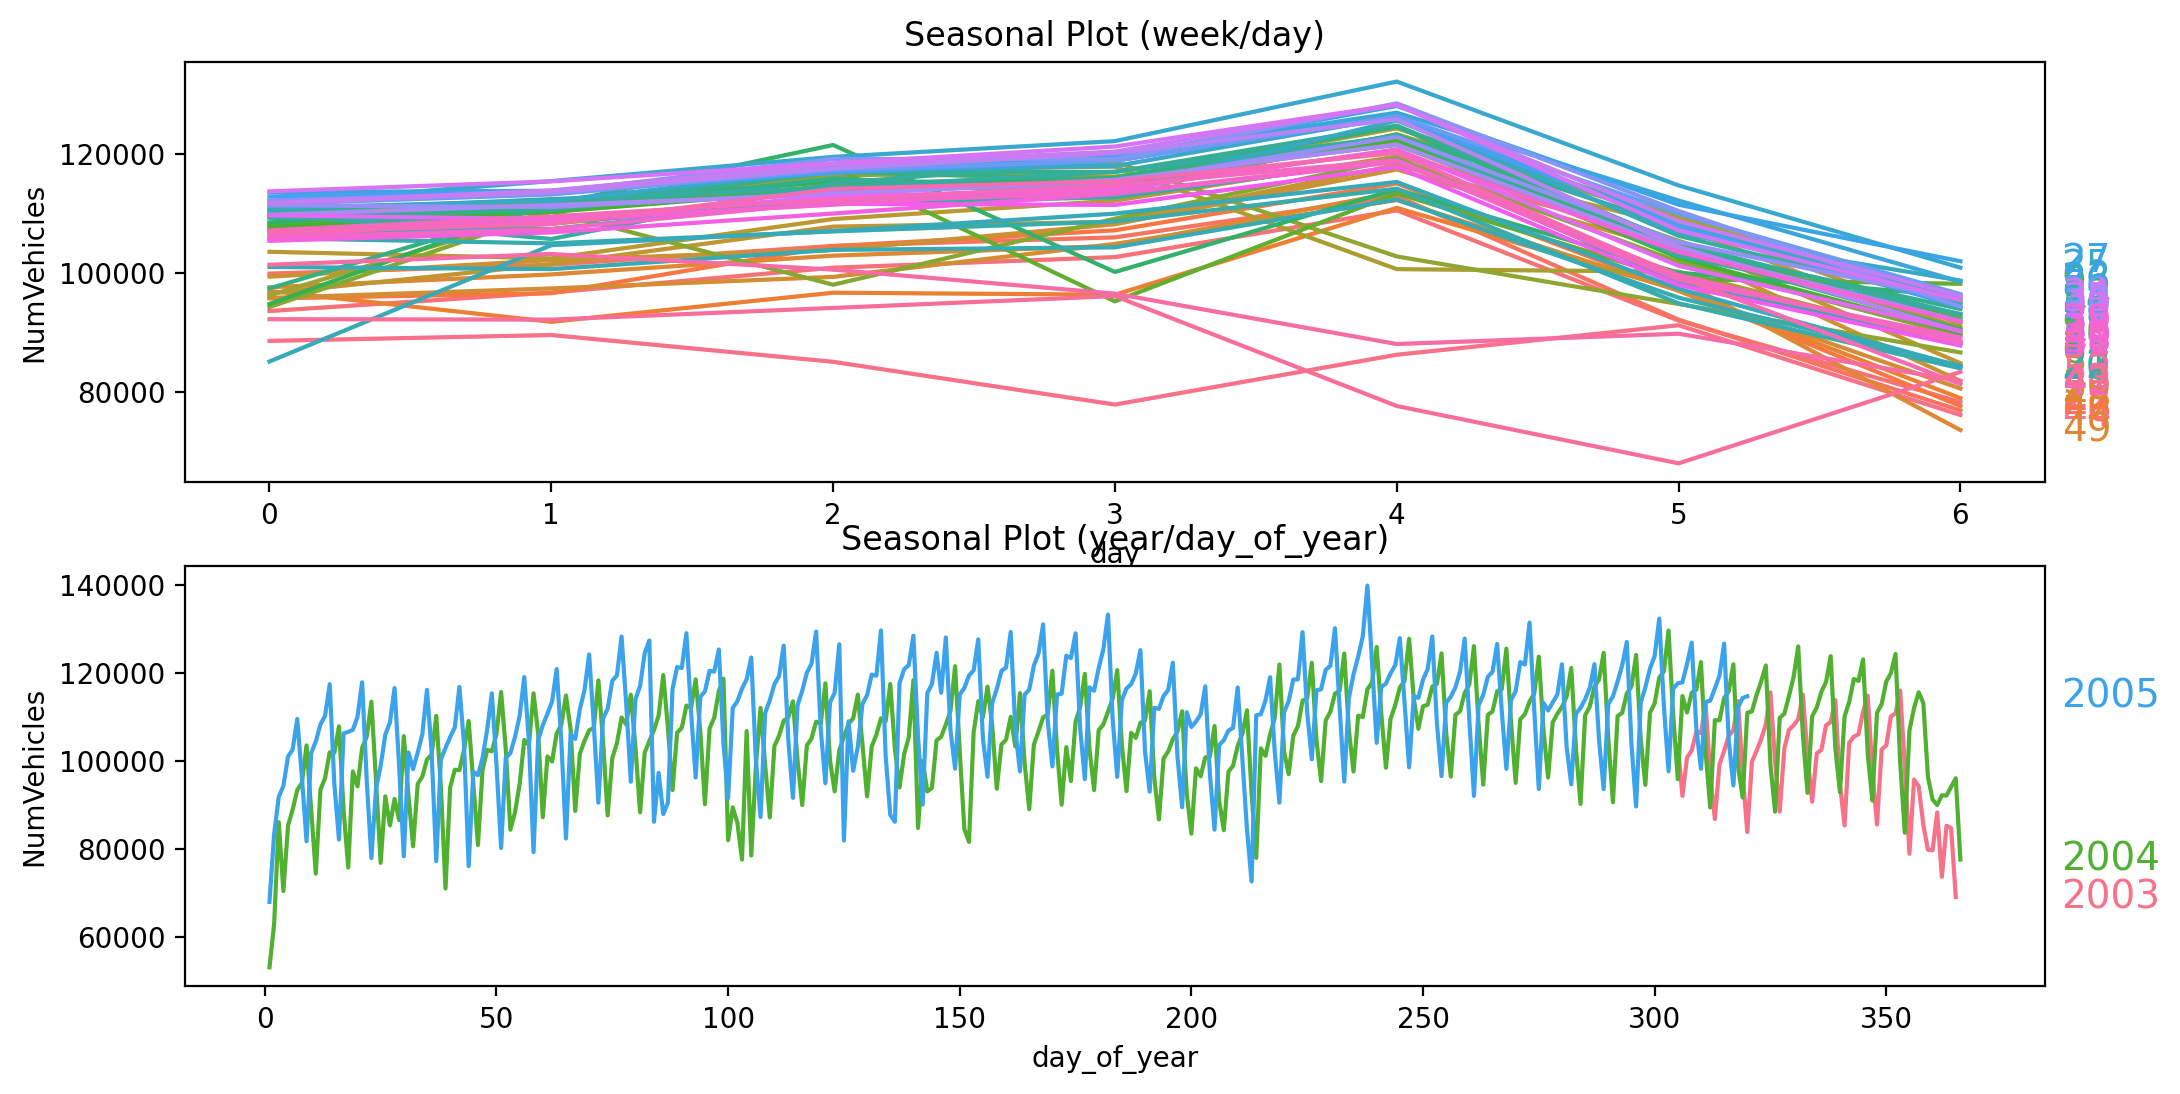

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(12,6))
seasonal_plot(work_df, y='NumVehicles', period='week', freq='day', ax=axs[0])
seasonal_plot(work_df, y='NumVehicles', period='year', freq='day_of_year', ax=axs[1])
plt.show()

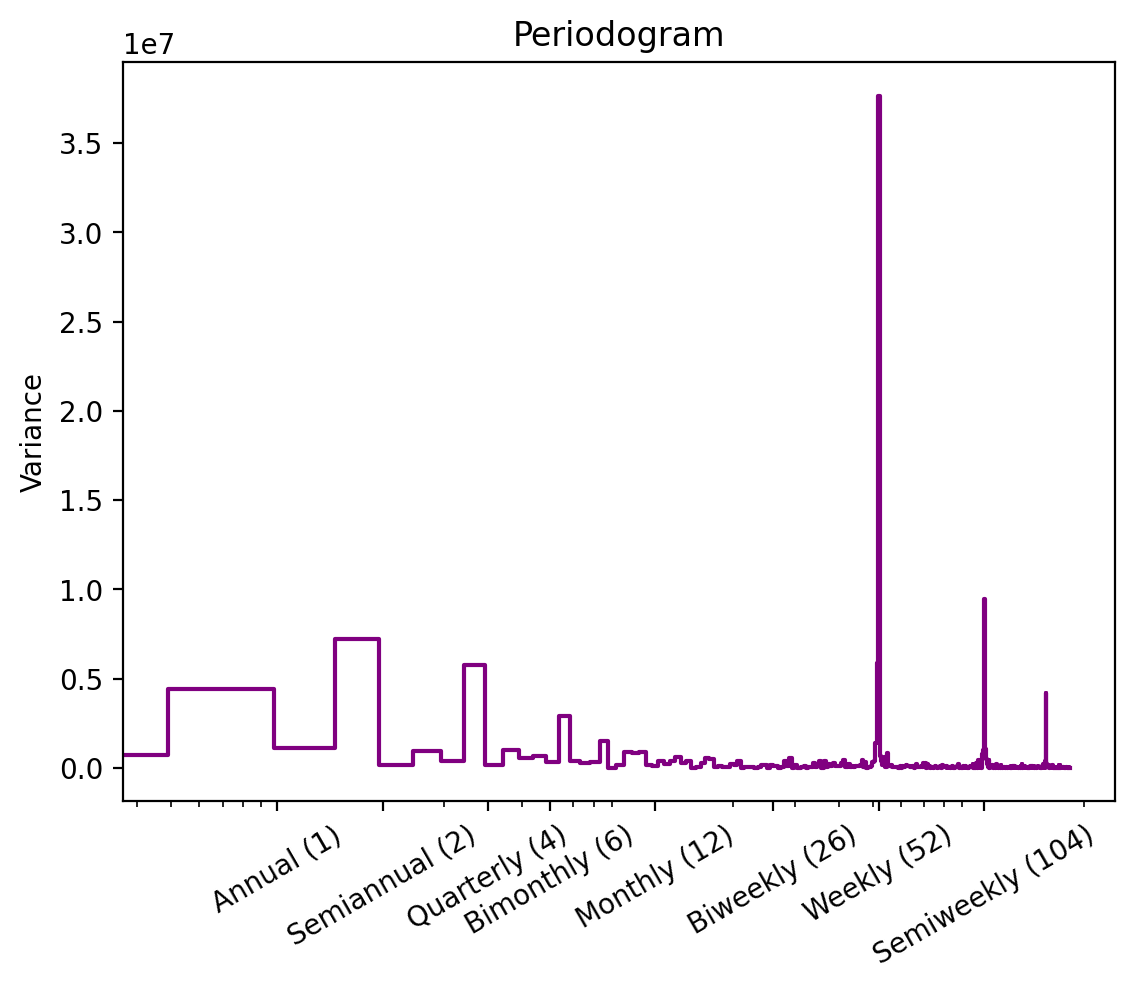

In [27]:
plot_periodogram(work_df.NumVehicles)
plt.show()